In [155]:
# imports to work with geoparquet
import geopandas as gpd
import pandas as pd

# varables
name_pref = "befolkning_1km_"
directory = "data/geoparquet/"
start_year = 2015
end_year = 2024

In [156]:
# import regSO geoparquet
regSO = gpd.read_parquet(directory + "RegSO_2025_Link.parquet")
#drop geometry column to avoid issues during merge
regSO = regSO.drop(columns="geometry")

# loop through years to concatenate data keeping all years in a single geodataframe without merging with regso
for year in range(start_year, end_year + 1):
    # import geoparquet for the year
    gdf_year = gpd.read_parquet(directory + name_pref + str(year) + ".parquet")
    # add year column
    gdf_year["year"] = year
    
    # concatenate to regSO
    if year == start_year:
        gdf_all_years = gdf_year
    else:
        gdf_all_years = pd.concat([gdf_all_years, gdf_year], ignore_index=True)

# add all RegSO data to the concatenated geodataframe based in rutid_inspire column
gdf_all_years = gdf_all_years.merge(regSO, on="rutid_inspire", how="left")
gdf_all_years = gdf_all_years.to_crs(epsg=3006)

In [157]:
gdf_all_years.head()
#print how many people are excluded in 2024 year due to na in regSO merge
excluded_2024 = gdf_all_years[(gdf_all_years["year"] == 2021) & (gdf_all_years["kommunnamn"].isna())]["beftotalt"].sum()
print(f"Number of people excluded in 2024 due to missing RegSO data: {excluded_2024}")


Number of people excluded in 2024 due to missing RegSO data: 3672


In [158]:
#drop all na values
gdf_all_years = gdf_all_years.dropna()

In [159]:
gdf_all_years.columns

Index(['objectid', 'rutid_inspire', 'rutid_scb', 'rutstorl', 'beftotalt',
       'kvinna', 'man', 'ald0_5', 'ald5_10', 'ald10_15', 'ald15_20',
       'ald20_25', 'ald25_30', 'ald30_35', 'ald35_40', 'ald40_45', 'ald45_50',
       'ald50_55', 'ald55_60', 'ald60_65', 'ald65_70', 'ald70_75', 'ald75_80',
       'ald80_85', 'ald85_90', 'ald90_95', 'ald95_100', 'ald100w',
       'referenstid', 'geometry', 'year', 'regsokod', 'regsonamn', 'lanskod',
       'kommunkod', 'kommunnamn', 'version'],
      dtype='object')

In [160]:
SUM_COLUMNS = ['rutstorl','beftotalt','ald0_5', 'ald5_10', 'ald10_15', 'ald15_20',
       'ald20_25', 'ald25_30', 'ald30_35', 'ald35_40', 'ald40_45', 'ald45_50',
       'ald50_55', 'ald55_60', 'ald60_65', 'ald65_70', 'ald70_75', 'ald75_80',
       'ald80_85', 'ald85_90', 'ald90_95', 'ald95_100', 'ald100w']
DROP_COLUMNS = ['rutid_inspire', 'rutid_scb', 'geometry', 'lanskod', 'regsonamn','referenstid','version','kvinna','man']

#drop unnecesary columns
gdf_all_years = gdf_all_years.drop(columns=DROP_COLUMNS)


#create a aggregation based on regsonamnskod and year columns and then divide all the summed columns by summing up the rutstorl column to get population density per region and year
gdf_aggregated = gdf_all_years.groupby(['regsokod', 'year'])[SUM_COLUMNS].sum().reset_index()
for col in SUM_COLUMNS:
    if col != 'rutstorl':
        gdf_aggregated[col] = gdf_aggregated[col] / (gdf_aggregated['rutstorl'] / 1000)

#the same for komnamnskod
gdf_aggregated_kom = gdf_all_years.groupby(['kommunkod', 'year'])[SUM_COLUMNS].sum().reset_index()
for col in SUM_COLUMNS:
    if col != 'rutstorl':
        gdf_aggregated_kom[col] = gdf_aggregated_kom[col] / (gdf_aggregated_kom['rutstorl'] / 1000)

In [161]:
gdf_with_kommun = gdf_all_years.merge(gdf_aggregated_kom, on=['kommunkod', 'year'], suffixes=('', '_kommun_sum'), how='left')
gdf_with_all = gdf_with_kommun.merge(gdf_aggregated, on=['regsokod', 'year'], suffixes=('', '_regso_sum'), how='left')
gdf_with_all.head()

,objectid,rutstorl,beftotalt,ald0_5,ald5_10,ald10_15,ald15_20,ald20_25,ald25_30,ald30_35,...,ald55_60_regso_sum,ald60_65_regso_sum,ald65_70_regso_sum,ald70_75_regso_sum,ald75_80_regso_sum,ald80_85_regso_sum,ald85_90_regso_sum,ald90_95_regso_sum,ald95_100_regso_sum,ald100w_regso_sum
0,319823,1000,1101,30,40,46,33,73,86,54,...,35.857143,35.428571,35.571429,35.285714,26.142857,27.00000,17.857143,7.000000,1.714286,0.428571
1,320219,1000,755,39,38,38,49,45,29,45,...,15.333333,19.666667,22.111111,16.722222,11.111111,9.50000,4.166667,2.555556,0.388889,0.166667
2,367204,1000,3,0,0,0,0,0,0,0,...,0.481250,0.581250,0.562500,0.456250,0.318750,0.20625,0.150000,0.106250,0.037500,0.000000
3,367601,1000,817,34,44,47,48,41,28,28,...,14.875000,17.125000,16.125000,15.250000,10.375000,9.75000,7.875000,3.500000,0.875000,0.375000
4,367989,1000,433,8,16,17,45,43,23,15,...,14.875000,17.125000,16.125000,15.250000,10.375000,9.75000,7.875000,3.500000,0.875000,0.375000


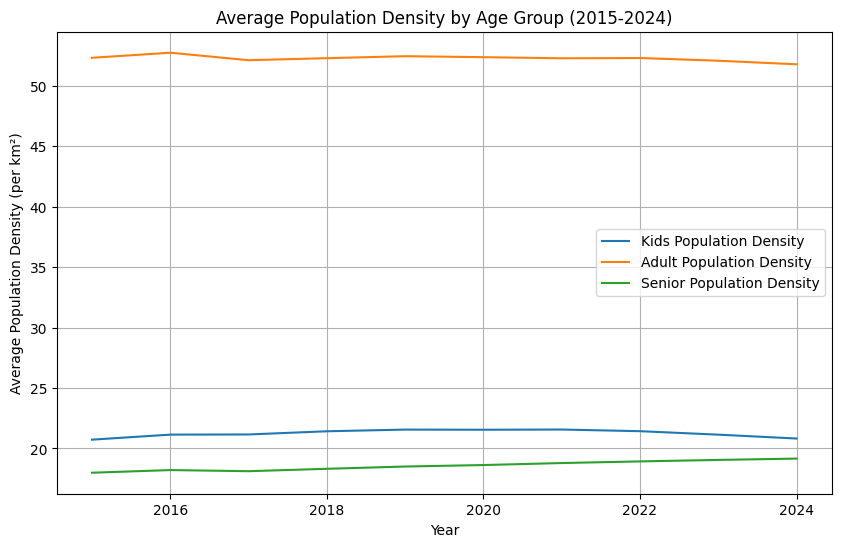

In [162]:
import matplotlib.pyplot as plt

#define the demographic ages
kids_cols = ['ald0_5', 'ald5_10', 'ald10_15', 'ald15_20']
adult_cols = ['ald20_25','ald25_30', 'ald30_35', 'ald35_40', 'ald40_45', 'ald45_50',
       'ald50_55', 'ald55_60', 'ald60_65']
senior_cols = ['ald65_70', 'ald70_75', 'ald75_80', 'ald80_85', 'ald85_90', 'ald90_95', 'ald95_100', 'ald100w']

#summing up the population for each demographic per year and then removing the original columns
gdf_with_all['kids_population'] = gdf_with_all[kids_cols].sum(axis=1)
gdf_with_all['adult_population'] = gdf_with_all[adult_cols].sum(axis=1)
gdf_with_all['senior_population'] = gdf_with_all[senior_cols].sum(axis=1)

#doing the same with the kommun and regso summed columns
gdf_with_all['kids_population_kommun_sum'] = gdf_with_all[[col + '_kommun_sum' for col in kids_cols]].sum(axis=1)
gdf_with_all['adult_population_kommun_sum'] = gdf_with_all[[col + '_kommun_sum' for col in adult_cols]].sum(axis=1)
gdf_with_all['senior_population_kommun_sum'] = gdf_with_all[[col + '_kommun_sum' for col in senior_cols]].sum(axis=1)
gdf_with_all['kids_population_regso_sum'] = gdf_with_all[[col + '_regso_sum' for col in kids_cols]].sum(axis=1)
gdf_with_all['adult_population_regso_sum'] = gdf_with_all[[col + '_regso_sum' for col in adult_cols]].sum(axis=1)
gdf_with_all['senior_population_regso_sum'] = gdf_with_all[[col + '_regso_sum' for col in senior_cols]].sum(axis=1)

#dropping the original columns
agedrop_cols = kids_cols + adult_cols + senior_cols + [col + '_kommun_sum' for col in kids_cols + adult_cols + senior_cols] + [col + '_regso_sum' for col in kids_cols + adult_cols + senior_cols]
gdf_with_all = gdf_with_all.drop(columns=agedrop_cols)

#ploting the average population density per year for kids, adults and seniors
avg_population_per_year = gdf_with_all.groupby('year')[['kids_population', 'adult_population', 'senior_population']].mean().reset_index()
plt.figure(figsize=(10,6))
plt.plot(avg_population_per_year['year'], avg_population_per_year['kids_population'], label='Kids Population Density')
plt.plot(avg_population_per_year['year'], avg_population_per_year['adult_population'], label='Adult Population Density')
plt.plot(avg_population_per_year['year'], avg_population_per_year['senior_population'], label='Senior Population Density')
plt.xlabel('Year')
plt.ylabel('Average Population Density (per km²)')
plt.title('Average Population Density by Age Group (2015-2024)')
plt.legend()
plt.grid()
plt.show()


In [163]:
gdf_with_all['regsokod'].head()

0    2283R006
1    2283R005
2    2463R001
3    2463R002
4    2463R002
Name: regsokod, dtype: object

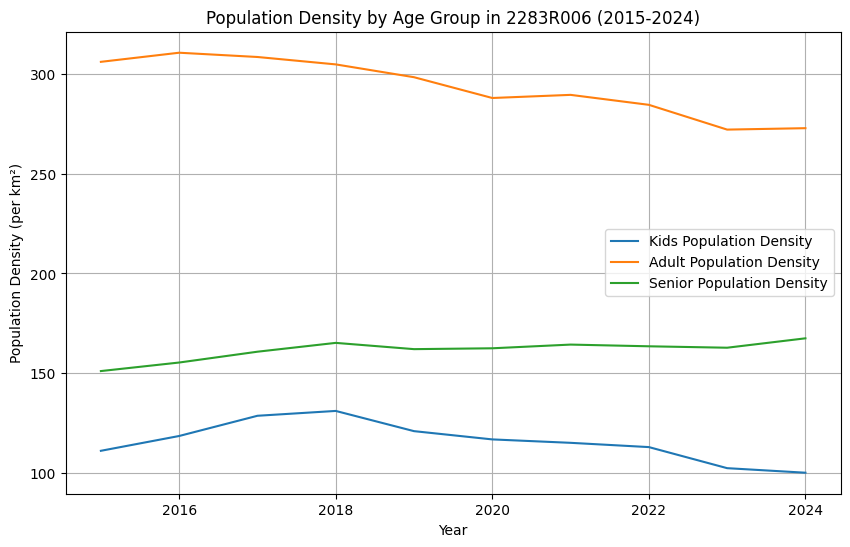

In [164]:
#plot the same but for a specific region by summing up the population densities for that region
region_code = "2283R006"  # example region code
region_data = gdf_with_all[gdf_with_all['regsokod'] == region_code]
region_population_per_year = region_data.groupby('year')[['kids_population', 'adult_population', 'senior_population']].mean().reset_index()
plt.figure(figsize=(10,6))
plt.plot(region_population_per_year['year'], region_population_per_year['kids_population'], label='Kids Population Density')
plt.plot(region_population_per_year['year'], region_population_per_year['adult_population'], label='Adult Population Density')
plt.plot(region_population_per_year['year'], region_population_per_year['senior_population'], label='Senior Population Density')
plt.xlabel('Year')
plt.ylabel('Population Density (per km²)')
plt.title(f'Population Density by Age Group in {region_code} (2015-2024)')
plt.legend()
plt.grid()
plt.show()

In [165]:
gdf_with_all.columns

Index(['objectid', 'rutstorl', 'beftotalt', 'year', 'regsokod', 'kommunkod',
       'kommunnamn', 'rutstorl_kommun_sum', 'beftotalt_kommun_sum',
       'rutstorl_regso_sum', 'beftotalt_regso_sum', 'kids_population',
       'adult_population', 'senior_population', 'kids_population_kommun_sum',
       'adult_population_kommun_sum', 'senior_population_kommun_sum',
       'kids_population_regso_sum', 'adult_population_regso_sum',
       'senior_population_regso_sum'],
      dtype='object')

In [166]:
#
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def feature_engineering(df, lag_y = 4):
    # Example feature engineering: create lag features for given columns
    lag_features = ['beftotalt', 'rutstorl_kommun_sum', 'beftotalt_kommun_sum',
       'rutstorl_regso_sum', 'beftotalt_regso_sum', 'kids_population',
       'adult_population', 'senior_population', 'kids_population_kommun_sum',
       'adult_population_kommun_sum', 'senior_population_kommun_sum',
       'kids_population_regso_sum', 'adult_population_regso_sum',
       'senior_population_regso_sum']
    #target year is the current year column
    for feature in lag_features:
        for lag in range(2, lag_y + 2): 
            df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
    
    # Drop rows with NaN values created by lag features
    df = df.dropna().reset_index(drop=True)
    return df

def run_xgboost_forecast(df, target_column, feature_columns, n_estimators=100, learning_rate=0.1, evaluate=True):

    # Split the data into training and testing sets
    X = df[feature_columns]
    y = df[target_column]

    #split based on year if evaluate is true, where test set is the last year
    if evaluate:
        train_years = df['year'] < df['year'].max()
        test_years = df['year'] == df['year'].max()
        X_train, X_test = X[train_years], X[test_years]
        y_train, y_test = y[train_years], y[test_years]
    else:
        X_train, y_train = X, y

    # Initialize the XGBoost regressor
    model = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)

    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Calculate the mean squared error
    if evaluate:
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        print(f"Mean Squared Error: {mse}")

    return model

#feature engineering
gdf_fe = feature_engineering(gdf_with_all, lag_y=4)
gdf_fe.columns

# Define target and feature columns
kids = 'kids_population'
adult = 'adult_population'
senior = 'senior_population'

feature_cols = [col for col in gdf_fe.columns if 'lag' in col]

# Run XGBoost forecast for kids population
print("Training model for kids population...")
kids_model = run_xgboost_forecast(gdf_fe, kids, feature_cols, n_estimators=200, learning_rate=0.05, evaluate=True)
# Run XGBoost forecast for adult population
print("Training model for adult population...")
adult_model = run_xgboost_forecast(gdf_fe, adult, feature_cols, n_estimators=200, learning_rate=0.05, evaluate=True)
# Run XGBoost forecast for senior population
print("Training model for senior population...")
senior_model = run_xgboost_forecast(gdf_fe, senior, feature_cols, n_estimators=200, learning_rate=0.05, evaluate=True)

Training model for kids population...
Mean Squared Error: 4110.44140625
Training model for adult population...
Mean Squared Error: 30016.40234375
Training model for senior population...
Mean Squared Error: 3966.831298828125


In [167]:
# feature engineer for prediction dataset
def feature_engineering_prediction(df, lag_y = 4,  predict_years = 2024):
    lag_features = ['beftotalt', 'rutstorl_kommun_sum', 'beftotalt_kommun_sum',
       'rutstorl_regso_sum', 'beftotalt_regso_sum', 'kids_population',
       'adult_population', 'senior_population', 'kids_population_kommun_sum',
       'adult_population_kommun_sum', 'senior_population_kommun_sum',
       'kids_population_regso_sum', 'adult_population_regso_sum',
       'senior_population_regso_sum']
   
    for feature in lag_features:
        for lag in range(2, lag_y + 2): 
            df[f'{feature}_lag_{lag}'] = df[feature].shift(lag-2)
    
    df = df[df['year'] == predict_years]
    df = df.dropna().reset_index(drop=True)
    return df

In [168]:
# feature engineer the original dataset for prediction year
gdf_predict = feature_engineering_prediction(gdf_with_all, lag_y=4, predict_years=2024)

# Define feature columns for prediction
feature_cols_predict = [col for col in gdf_predict.columns if 'lag' in col]

# Make predictions for kids, adults, and seniors
gdf_predict['kids_population_pred'] = kids_model.predict(gdf_predict[feature_cols_predict])
gdf_predict['adult_population_pred'] = adult_model.predict(gdf_predict[feature_cols_predict])
gdf_predict['senior_population_pred'] = senior_model.predict(gdf_predict[feature_cols_predict])

#aggregate predictions per region
gdf_predictions_aggregated = gdf_predict.groupby('kommunnamn')[['beftotalt','rutstorl','kids_population_pred', 'adult_population_pred', 'senior_population_pred']].sum().reset_index()
gdf_predictions_aggregated.head()

,kommunnamn,beftotalt,rutstorl,kids_population_pred,adult_population_pred,senior_population_pred
0,Ale,34879,243000,8472.724609,17011.830078,5704.970215
1,Alingsås,42485,416000,9634.638672,21911.394531,8389.712891
2,Alvesta,19806,637000,5025.570801,11682.270508,5228.520996
3,Aneby,6730,342000,2053.437988,4892.188965,2365.884521
4,Arboga,13916,237000,2558.563232,6314.261230,3260.939697


In [169]:
#get the increase in population per region compared to the original 2024 data
gdf_2024 = gdf_with_all[gdf_with_all['year'] == 2024]
gdf_2024_agg = gdf_2024.groupby('kommunnamn')[['kids_population', 'adult_population', 'senior_population']].sum().reset_index()
gdf_comparison = gdf_2024_agg.merge(gdf_predictions_aggregated, on='kommunnamn', how='left')
gdf_comparison['kids_population_increase_p'] = (gdf_comparison['kids_population_pred'] - gdf_comparison['kids_population']) / gdf_comparison['kids_population'] * 100
gdf_comparison['adult_population_increase_p'] = (gdf_comparison['adult_population_pred'] - gdf_comparison['adult_population']) / gdf_comparison['adult_population'] * 100
gdf_comparison['senior_population_increase_p'] = (gdf_comparison['senior_population_pred'] - gdf_comparison['senior_population']) / gdf_comparison['senior_population'] * 100

gdf_comparison.head()

,kommunnamn,kids_population,adult_population,senior_population,beftotalt,rutstorl,kids_population_pred,adult_population_pred,senior_population_pred,kids_population_increase_p,adult_population_increase_p,senior_population_increase_p
0,Ale,9509,19520,5987,34879,243000,8472.724609,17011.830078,5704.970215,-10.897838,-12.849231,-4.710703
1,Alingsås,10310,22363,9915,42485,416000,9634.638672,21911.394531,8389.712891,-6.550546,-2.019432,-15.383632
2,Alvesta,4922,10238,4697,19806,637000,5025.570801,11682.270508,5228.520996,2.104242,14.106959,11.316180
3,Aneby,1604,3486,1642,6730,342000,2053.437988,4892.188965,2365.884521,28.019825,40.338180,44.085537
4,Arboga,2877,7172,3835,13916,237000,2558.563232,6314.261230,3260.939697,-11.068362,-11.959548,-14.968978


In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration (Based on your final DataFrame columns) ---
REGION_NAME_COL = 'kommunnamn'
FORECAST_YEAR = 2026

# The confirmed names for the predicted absolute increase (Y-axis)
INCREASE_COLS = {
    'Kids': 'kids_population_increase_p',
    'Adults (HPP)': 'adult_population_increase_p',
    'Seniors (Retired)': 'senior_population_increase_p'
}
# X-axis: Current Total Population (Market Size Proxy)
DENSITY_COL = 'beftotalt' 

df_final_regional = gdf_comparison.copy() 

def plot_quadrant_matrix_absolute(df, increase_col, title):
    """
    Generates the Strategic Quadrant Matrix Plot with:
    1. Absolute Predicted Increase on Y-axis (centered at 0).
    2. Population on the X-axis using a LOG SCALE, centered on the MEAN population.
    """
    df_plot = df.copy()
    
    # NOTE: Assuming df_plot is already aggregated to the commune level.
    REGION_NAME_COL = 'kommunnamn'
    DENSITY_COL = 'beftotalt'
    FORECAST_YEAR = 2026

    # --- Data Setup ---
    # Filter to the top 20 most populous communes for strategic focus
    top_n = 20
    df_plot = df_plot.nlargest(top_n, DENSITY_COL).copy()
    
    # --- Define Strategic Centers/Thresholds ---
    # Y-axis strategic center (Growth Threshold) is FIXED AT ZERO
    increase_threshold = 0 
    
    # X-axis strategic center (Density Threshold) is now the MEAN population
    density_mean = df_plot[DENSITY_COL].mean()
    
    # 1. Log-Center the X-axis on the MEAN (new logic)
    # Use log base 10 for standard visualization
    log_data = np.log10(df_plot[DENSITY_COL])
    log_mean = np.log10(density_mean)
    
    # Calculate the maximum distance (offset) from the log mean to the data extremes
    max_offset = np.max([log_mean - log_data.min(), log_data.max() - log_mean])
    
    # Add a small buffer for aesthetic padding
    buffer = 0.05 
    
    # Set the symmetric log limits
    log_xlim_min = log_mean - max_offset - buffer
    log_xlim_max = log_mean + max_offset + buffer
    
    # Convert back to natural scale for plotting limits (10^log_limit)
    data_xlim_min = 10**log_xlim_min
    data_xlim_max = 10**log_xlim_max
    
    # --- Quadrant Classification ---
    # The dividing line for the quadrants is now the MEAN
    high_density = df_plot[DENSITY_COL] >= density_mean
    low_density = df_plot[DENSITY_COL] < density_mean
    high_growth = df_plot[increase_col] >= increase_threshold
    low_growth = df_plot[increase_col] < increase_threshold
    
    # Classify regions
    df_plot.loc[high_density & high_growth, 'Quadrant'] = '1. Golden Markets (Above Average Pop, Growth)'
    df_plot.loc[low_density & high_growth, 'Quadrant'] = '2. Future Hubs (Below Average Pop, Growth)'
    df_plot.loc[high_density & low_growth, 'Quadrant'] = '3. Mature/Declining (Above Average Pop, Decline)'
    df_plot.loc[low_density & low_growth, 'Quadrant'] = '4. Non-Strategic/Shrinking (Below Average Pop, Decline)'

    # --- Visualization ---
    plt.figure(figsize=(10, 10))
    
    # Apply LOG SCALE and centered limits
    plt.xscale('log')
    plt.xlim(data_xlim_min, data_xlim_max)
    
    # Set Y-axis limits symmetrically around 0
    max_abs_y = df_plot[increase_col].abs().max()
    plt.ylim(-max_abs_y * 1.1, max_abs_y * 1.1)
    
    sns.scatterplot(
        x=DENSITY_COL, 
        y=increase_col, 
        hue='Quadrant', 
        data=df_plot, 
        palette='Spectral', 
        s=150
    )
    
    # Horizontal strategic line (Y=0)
    plt.axhline(increase_threshold, color='r', linestyle='-', linewidth=1.5, 
                label='Growth Center (Zero Change)')
    
    # Vertical strategic line (at the MEAN, which is now the visual center)
    plt.axvline(density_mean, color='b', linestyle='--', linewidth=1, 
                label=f'Density Center (Mean Pop: {int(density_mean/1000):,}K)')
    
    # Format X-axis ticks to display powers of 10 nicely
    plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(
        lambda x, p: format(int(x), ',')
    ))
    
    # Format Y-axis ticks for readability (in absolute numbers)
    plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(
        lambda y, p: format(int(y), ',')
    ))

    # Add labels for key communes
    if REGION_NAME_COL in df_plot.columns:
        for i in df_plot.index:
            plt.annotate(df_plot[REGION_NAME_COL][i], 
                         # Use log-transformed X position for annotation placement
                         (df_plot[DENSITY_COL][i] * 1.05, df_plot[increase_col][i]), 
                         fontsize=8)

    plt.title(f'Strategic Quadrant Analysis: {title} (Commune Level Forecast {FORECAST_YEAR})')
    plt.xlabel('2024 Total Commune Population (Market Size Proxy - LOG SCALE, Centered on MEAN)')
    plt.ylabel(f'{title} Predicted ABSOLUTE Increase (2024-{FORECAST_YEAR}, Number of People)')
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, title='Strategic Quadrant')
    plt.tight_layout()
    
    # Save the plot
    file_title = title.lower().replace(" ", "_").replace("(","_").replace(")","")
    plt.savefig(f'quadrant_matrix_log_centered_{file_title}.png')
    plt.close()
    
    print(f"Quadrant Matrix plot for {title} saved as 'quadrant_matrix_log_centered_{file_title}.png'.")
# --- 3. Execution ---
for title, col in INCREASE_COLS.items():
    plot_quadrant_matrix_absolute(df_final_regional.copy(), col, title)

print("\n--- Centered Absolute Increase Quadrant Matrix Visualization Code Ready ---")

Quadrant Matrix plot for Kids saved as 'quadrant_matrix_log_centered_kids.png'.
Quadrant Matrix plot for Adults (HPP) saved as 'quadrant_matrix_log_centered_adults__hpp.png'.
Quadrant Matrix plot for Seniors (Retired) saved as 'quadrant_matrix_log_centered_seniors__retired.png'.

--- Centered Absolute Increase Quadrant Matrix Visualization Code Ready ---


In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# NOTE: This library is required for the code below to run correctly. 
# If you receive a ModuleNotFoundError, you need to install it (e.g., pip install matplotlib-venn).
# from matplotlib_venn import venn3_unweighted 

# --- Configuration ---
REGION_NAME_COL = 'kommunnamn'
FORECAST_YEAR = 2026
INCREASE_COLS = {
    'Kids': 'kids_population_increase_p',
    'Adults (HPP)': 'adult_population_increase_p',
    'Seniors (Retired)': 'senior_population_increase_p'
}

# 1. Load Data (Assumes gdf_comparison is available)
df = gdf_comparison.copy() 

# 2. Filter: Only include regions predicted to grow (increase > 0) in AT LEAST ONE dimension.
growth_filter = (
    (df[INCREASE_COLS['Kids']] > 0) |
    (df[INCREASE_COLS['Adults (HPP)']] > 0) |
    (df[INCREASE_COLS['Seniors (Retired)']] > 0)
)
df_growing = df[growth_filter].copy()

# 3. Define Relative "High Growth" Thresholds (Median of the growing regions)
kids_growth_threshold = df_growing[INCREASE_COLS['Kids']].median()
adult_growth_threshold = df_growing[INCREASE_COLS['Adults (HPP)']].median()
senior_growth_threshold = df_growing[INCREASE_COLS['Seniors (Retired)']].median()

# --- 4. Set Creation for Overlap Calculation ---
# Use the DataFrame index as a unique ID for the set operations
set_kids_growth = set(df_growing[df_growing[INCREASE_COLS['Kids']] > kids_growth_threshold].index)
set_adult_growth = set(df_growing[df_growing[INCREASE_COLS['Adults (HPP)']] > adult_growth_threshold].index)
set_senior_growth = set(df_growing[df_growing[INCREASE_COLS['Seniors (Retired)']] > senior_growth_threshold].index)

# Define the sets for easier logic
A = set_kids_growth
B = set_adult_growth
C = set_senior_growth

# Calculate all 7 non-overlapping segments required by venn3_unweighted
# Order: (A\B\C, B\A\C, A^B\C, C\A\B, A^C\B, B^C\A, A^B^C)
subsets = (
    len(A - B - C),                  # Kids Only (a)
    len(B - A - C),                  # Adults Only (b)
    len(A.intersection(B) - C),      # Kids & Adults (ab)
    len(C - A - B),                  # Seniors Only (c)
    len(A.intersection(C) - B),      # Kids & Seniors (ac)
    len(B.intersection(C) - A),      # Adults & Seniors (bc)
    len(A.intersection(B).intersection(C)) # All Three (abc)
)
#pick names for each segment by randomly choosing a kommun in the subset
subsets = (
    "\n".join(df_growing.loc[list(A - B - C), REGION_NAME_COL].sample(2).values),
    "\n".join(df_growing.loc[list(B - A - C), REGION_NAME_COL].sample(2).values),
    "\n".join(df_growing.loc[list(A.intersection(B) - C), REGION_NAME_COL].sample(2).values),
    "\n".join(df_growing.loc[list(C - A - B), REGION_NAME_COL].sample(2).values),
    "\n".join(df_growing.loc[list(A.intersection(C) - B), REGION_NAME_COL].sample(2).values),
    "\n".join(df_growing.loc[list(B.intersection(C) - A), REGION_NAME_COL].sample(2).values),
    "\n".join(df_growing.loc[list(A.intersection(B).intersection(C)), REGION_NAME_COL].sample(3).values)
)

# --- 5. Venn Diagram Visualization ---
from matplotlib_venn import venn3_unweighted

plt.figure(figsize=(10, 8))
venn3_unweighted(
    subsets=subsets,
    set_labels=('Kids (Above Median Growth)', 'Adults (HPP, Above Median Growth)', 'Seniors (Above Median Growth)'),
    set_colors=('skyblue', 'lightcoral', 'lightgreen'),
    alpha=0.7
)

plt.title(f'Overlap of High-Growth Communes (2024-{FORECAST_YEAR})')
plt.tight_layout()
plt.savefig('market_overlap_venn_diagram.png')
plt.close()
print("Venn Diagram saved as 'market_overlap_venn_diagram.png'.")


C:\Users\Ludvig Nordberg\AppData\Roaming\Python\Python313\site-packages\matplotlib_venn\_util.py:62: UserWarning: venn3_unweighted is deprecated. Use venn3 with the appropriate layout_algorithm instead.
  warnings.warn(


Venn Diagram saved as 'market_overlap_venn_diagram.png'.
